In [1]:
# Leaky integrator model of Echo State Network
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

In [2]:
def correct_dimensions(s, targetlength):
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class LI_ESN_internal:

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 internal_node=5,
                 random_state=None, time_scale=None):
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.internal_node = internal_node
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state
        self.time_scale = time_scale

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = np.random.normal(0, 2.4/self.n_reservoir, (self.n_reservoir, self.n_reservoir))
        
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = (np.random.rand(self.n_reservoir, self.n_inputs) * 2 - 1)*0.1
        self.W_in[-self.internal_node:] = [0]

    def _update(self, state, input_pattern):
        # leaky integrator model
        preactivation = (np.dot(self.W, state)
                         + np.dot(self.W_in, input_pattern))
        state = (1 - self.time_scale) * state + self.time_scale * np.tanh(preactivation)
        return (state + self.noise * self.time_scale * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def calc_lyapunov_exp(self, inputs, initial_distance, n):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        states1 = np.zeros((inputs.shape[0], self.n_reservoir))
        states2 = np.zeros((inputs.shape[0], self.n_reservoir))
        transient = min(int(inputs.shape[0] / 10), 100)
        for i in range(1, transient):
            states1[i, :] = self._update(states1[i-1], inputs[i, :])
        states2[transient-1, :] = states1[transient-1, :]
        states2[transient-1, n] = states2[transient-1, n] + initial_distance
        gamma_k_list = []
        for k in range(transient, inputs.shape[0]):
            states1[k, :] = self._update(states1[k-1], inputs[k, :])
            states2[k, :] = self._update(states2[k-1], inputs[k, :])
            gamma_k = np.linalg.norm(states2[k, :]-states1[k, :])
            # print(gamma_k/initial_distance)
            gamma_k_list.append(gamma_k/initial_distance)
            states2[k, :] = states1[k, :] + (initial_distance/gamma_k)*(states2[k, :]-states1[k, :])
        lyapunov_exp = np.mean(np.log(gamma_k_list))
        return lyapunov_exp
            
    
    def fit(self, inputs, outputs):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        inputs_scaled = inputs
        teachers_scaled = outputs

        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :])
        transient = min(int(inputs.shape[0] / 10), 100)
        
        self.W_out = np.dot(np.linalg.pinv(states[transient:, :-self.internal_node]),teachers_scaled[transient:, :]).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]
            
        # apply learned weights to the collected states:
        # print(states.shape)
        pred_train = np.dot(states[:, :-self.internal_node], self.W_out.T)
        # print(self.W_out.T.shape)
        return pred_train

    def predict(self, inputs, continuation=True):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, inputs])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :])
            outputs[n + 1, :] = np.dot(self.W_out,states[n + 1, :-self.internal_node])

        return self.out_activation(outputs[1:])


In [3]:
def make_data_for_narma(length):
    tau = 0.01
    buffer = 100
    x = np.random.rand(length+100)*0.5
    y = np.zeros(length)
    for i in range(length):
        if i < 29:
            y[i] = 0.2*y[i-1] + 0.004*y[i-1]*np.sum(np.hstack((y[i-29:], y[:i]))) + 1.5*x[i-29+100]*x[i+100] + 0.001
        else:
            y[i] = 0.2*y[i-1] + 0.004*y[i-1]*np.sum(np.hstack((y[i-29:i]))) + 1.5*x[i-29+100]*x[i+100] + 0.001
    return x, y

In [4]:
N = 150
# spectral radius
rou = 0.93
trainlen = 2200
future = 1000
buffer = 100


time_scale = np.ones(N)
# time_scale[0] = 0.01
# time_scale[-5:-2] = 0.7
# time_scale[30:35] = 0.2
# time_scale[35:37] = 0.1
# time_scale[-1] = 0.01

In [85]:
time_scale = np.ones(N)
time_scale[-10:] = 0.1

data, target = make_data_for_narma(trainlen+future)
rou = 0.93
esn = LI_ESN_internal(n_inputs=1,
                      n_outputs=1,
                      n_reservoir=N,
                      sparsity=0.935,
                      noise=0,
                      internal_node=5,
                      spectral_radius=rou,
                      time_scale=time_scale)

pred_training = esn.fit(data[buffer:buffer+trainlen], target[:trainlen])

prediction = esn.predict(data[trainlen+buffer:])
narma = np.sqrt(np.mean((np.reshape(prediction, -1)-np.reshape(target[2200:], -1))**2)/np.var(target[2200:]))
print(narma)
print(esn.calc_lyapunov_exp(data[buffer:buffer+trainlen], 1e-12, 0))

0.45072265724650795
-0.08406788900533774


In [5]:
nrmse_list = []
lyap_exp_list = []
for i in range(1000):
    data, target = make_data_for_narma(trainlen+future)
    rou = np.random.rand()*1.5
    esn = LI_ESN_internal(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=N,
                          sparsity=0.935,
                          noise=0,
                          internal_node=5,
                          spectral_radius=rou,
                          time_scale=time_scale)


    pred_training = esn.fit(data[buffer:buffer+trainlen], target[:trainlen])

    prediction = esn.predict(data[trainlen+buffer:])
    narma = np.sqrt(np.mean((np.reshape(prediction, -1)-np.reshape(target[2200:], -1))**2)/np.var(target[2200:]))
    nrmse_list.append(narma)
    lyap_exp_list.append(esn.calc_lyapunov_exp(data[buffer:buffer+trainlen], 1e-12, 0))
    

KeyboardInterrupt: 

In [ ]:
print(nrmse_listmean(nrmse_list), np.sqrt(np.var(nrmse_list)))

In [303]:
np.std(nrmse_list)

0.02652721455136195

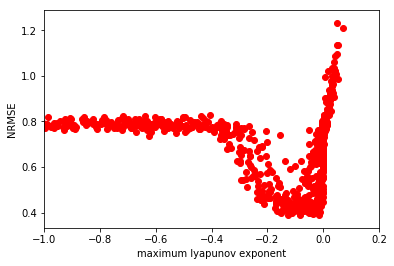

In [316]:
plt.scatter(lyap_exp_list, nrmse_list, color='red')
plt.xlim([-1,0.2])
plt.xlabel("maximum lyapunov exponent")
plt.ylabel("NRMSE")
# plt.show()
plt.savefig("edgeofchaos.png")

In [ ]:
narma = np.sqrt(np.mean((np.reshape(prediction, -1)-np.reshape(target[2200:], -1))**2)/np.var(target[2200:]))
print(narma)

In [77]:
esn.calc_lyapunov_exp(data[buffer:buffer+trainlen], 1e-12, 0)

-0.07596721002856839

In [211]:
def memory_capacity(L, buffer, data, output_data):
    trainlen = 1200
    MC = 0
    for k in range(L):
        cov_matrix = np.cov(np.array([data[trainlen+buffer-(k+1): trainlen+buffer-(k+1)+1000],output_data.T[k]]))
        MC_k = cov_matrix[0][1]**2
        # print(MC_k)
        MC_k = MC_k / (np.var(data[trainlen+buffer:])*np.var(output_data.T[k]))
        # print(np.var(data[trainlen+buffer:])*np.var(output_data.T[k]))
        # print(MC_k)
        MC += MC_k
    return MC

In [311]:
N = 155
# delayed signal
L = int(100*1.4)
time_scale = np.ones(N)*0.95

buffer = L
total_len = 2200 + buffer
tau = 0.01
data = (np.random.rand(total_len)*2-1)*tau


esn = LI_ESN_internal(n_inputs=1,
                      n_outputs=L,
                      n_reservoir=N,
                      noise=0,
                      internal_node=5,
                      spectral_radius=rou,
                      time_scale=time_scale)


target = np.zeros((total_len - buffer, L))
for i in range(L):
    target.T[i][:] = data[buffer-(i+1):-(i+1)]

pred_training = esn.fit(data[buffer:trainlen+buffer], target[:trainlen])

prediction = esn.predict(data[trainlen+buffer:])


    
print(memory_capacity(L, buffer, data, prediction))


66.21613574345129
